# This notebook uses jet data to regress soft drop mass using deepsets

## Imports

In [2]:
# torch imports
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# other imports
import os
import uproot
import vector
import awkward as ak
vector.register_awkward()
import pandas as pd
import numpy as np
from tqdm import tqdm

## Runtime settings

In [4]:
# device to run
device = 'cpu' # gpu, mps

# dataset path
dataset_path = '../data/JetClass_example_100k.root'

## Create point clouds

In [5]:
class JetToPC(data.Dataset):
    """
     This class returns jet data as set of point clouds
    """

    def __init__(self, dataset_path:str, tree_name:str = 'tree') -> None:

        super().__init__()
        
        self.dataset = uproot.open(dataset_path)
        self.tree = self.dataset[tree_name].arrays()
        self.num_entries = self.dataset[tree_name].num_entries
        

    def transform_jet_to_point_cloud(self, idx:int) -> dict :
    
        npart = self.tree['jet_nparticles'].to_numpy()[idx]  # get number of particles
    
        
        part_deta = self.tree['part_deta'][idx].to_numpy()  # deta
        part_dphi = self.tree['part_dphi'][idx].to_numpy()  # dphi
        part_pt = np.sqrt(                                  # pt
            self.tree['part_px'][idx].to_numpy()**2 +\
            self.tree['part_py'][idx].to_numpy()**2
        )
        
        jet_sd_mass = self.tree['jet_sdmass'].to_numpy()[idx]  # sd_mass
             
        part_feat = np.stack([part_dphi, part_deta]).T
#         print(part_feat.shape)
#         print(part_pt.reshape(len(part_pt), 1).shape)
        
        return {
            'jet' : torch.tensor(part_feat), 
            'seq_length' : torch.tensor(npart), 
            'sd_mass' : torch.tensor(jet_sd_mass),
            'pt': torch.tensor(part_pt.reshape(len(part_pt), 1))
        }     
        

    def __len__(self) -> int:
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.num_entries
    
    def __getitem__(self, idx:int) -> dict :
        # Return the idx-th data point of the dataset
        return self.transform_jet_to_point_cloud(idx)


## Create batches 

In [6]:
def createBatch(data_list : list) -> tuple : 
    """
     This function creates mini batches from the dataset
    """
    
    max_length = np.max([int(data_list[idx]['seq_length'].item()) for idx in range(len(data_list))])
    pc_list, sd_mass_list, pt_list = [], [], []
    
#     print(max_length)
    
    for idx in range(len(data_list)) : 
        
        pc, sd_mass, pt = data_list[idx]['jet'], data_list[idx]['sd_mass'], data_list[idx]['pt']
        npart, featnum = pc.shape[0], pc.shape[1]
        
        # invoke zero padding
        pc_padded = torch.zeros([1, max_length, featnum])
        pt_padded = torch.zeros([1, max_length, 1])
        pc = pc.reshape(1, npart, featnum)
        pt = pt.reshape(1, npart, 1)
        pc_padded[:,0:npart,:] = pc
        pt_padded[:,0:npart,:] = pt
        
        # append to batch list
        pc_list.append(pc_padded)
        sd_mass_list.append(torch.tensor([sd_mass]))
        pt_list.append(pt_padded)
    
    return torch.cat(pc_list, dim=0), torch.cat(sd_mass_list, dim=0), torch.cat(pt_list, dim=0)

## Setup Deep Set Layer 

In [7]:
class DeepSetLayer(nn.Module):
    """
     This class creates a deep set layer with EnergyFlow parametrisation
    """
    
    def __init__(
        self, 
        in_features:int, 
        out_features_lambda:int, 
        out_features_gamma:int,  
        normalization:str = '', 
        pool:str = 'mean'
    ) -> None :
        
        super().__init__()
        
        # define functionaal parameters
        self.Gamma = nn.Linear(out_features_lambda, out_features_gamma)
        self.Lambda = nn.Linear(in_features, out_features_lambda)

        self.normalization = normalization
        self.pool = pool
        
        if normalization == 'batchnorm':
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x : torch.Tensor, pt_list : torch.Tensor) -> torch.Tensor :
        
        lambdaout = self.Lambda(x)
        
        if pt_list.shape[1]==lambdaout.shape[1]:
            y = pt_list*lambdaout
        else:
            y = torch.bmm(pt_list, lambdaout)
        
        x = self.Gamma(torch.sum(y, 1, keepdim=True))
#         print(x.shape)
        
        return x

In [8]:
class DeepSetLayerNew(nn.Module):
    """
     This class creates a deep set layer with EnergyFlow parametrisation
    """
    
    def __init__(
        self, 
        in_features:int, 
        out_features:int,   
        normalization:str = '', 
        pool:str = 'mean'
    ) -> None :
        
        super().__init__()
        
        # define functionaal parameters
        self.Transformer = nn.Linear(in_features, out_features)

        self.normalization = normalization
        self.pool = pool
        
        if normalization == 'batchnorm':
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x : torch.Tensor) -> torch.Tensor :
        
        x = self.Transformer(x)
        return x

## Setup Deep Set

In [9]:
class DeepSet(nn.Module):
    """
     This function implements 
    """
    
    def __init__(
        self, 
        in_features:int, 
        feats_gamma:list, 
        feats_lambda:list, 
        normalization:str = '', 
        pool:str = 'mean'
    ) ->None:
        
        super().__init__()
        
        # initialise layers
        layers = []
        
        # input layer
        layers.append(DeepSetLayer(
            in_features=in_features, 
            out_features_lambda=feats_lambda[0], 
            out_features_gamma=feats_gamma[0], 
            normalization=normalization, 
            pool=pool
        ))
        
        # hidden layers
        for i in range(1, len(feats_gamma)):
            
            layers.append(nn.ReLU()) # activation layer
            layers.append(DeepSetLayer(
                in_features=feats_gamma[i-1], 
                out_features_lambda=feats_lambda[i], 
                out_features_gamma=feats_gamma[i], 
                normalization = normalization, 
                pool = pool)
            )
        
        # output layer
        layers.append(DeepSetLayer(
            in_features=feats_gamma[-1], 
            out_features_lambda=feats_lambda[-1], 
            out_features_gamma=1, 
            normalization=normalization, pool = pool
        ))
        
        # define sequential
        self.sequential = nn.ModuleList(layers)

    def forward(self, x:torch.Tensor, pt_list : torch.Tensor) -> torch.Tensor:
        #return self.sequential(x)
        for i, layer in enumerate(self.sequential):
            if isinstance(layer, nn.ReLU):
                x = layer(x)
            else:
                x = layer(x, pt_list)
        
        out = torch.sum(x, dim=[1,2])
        return out

In [10]:
class DeepSetNew(nn.Module):
    """
     This function implements 
    """
    
    def __init__(
        self, 
        in_features:int, 
        feats_gamma:list, 
        feats_lambda:list, 
        normalization:str = '', 
        pool:str = 'mean'
    ) ->None:
        
        super().__init__()
        
        self.feats_lambda = feats_lambda
        
        # initialise layers
        layers = []
        
        # input layer to lambda
        layers.append(DeepSetLayerNew(
            in_features=in_features, 
            out_features=feats_lambda[0],  
            normalization=normalization, 
            pool=pool
        ))
        
        # hidden layers for lambda
        for i in range(1, len(feats_lambda)):
            
            layers.append(nn.ReLU()) # activation layer
            layers.append(DeepSetLayerNew(
                in_features=feats_lambda[i-1], 
                out_features=feats_lambda[i],  
                normalization = normalization, 
                pool = pool)
            )
        
        # input layer to gamma
        layers.append(DeepSetLayerNew(
            in_features=feats_lambda[-1], 
            out_features=feats_gamma[0],  
            normalization=normalization, 
            pool=pool
        ))
        
#       # hidden layers for gamma
        for i in range(1, len(feats_gamma)):
            
            layers.append(nn.ReLU()) # activation layer
            layers.append(DeepSetLayerNew(
                in_features=feats_gamma[i-1], 
                out_features=feats_gamma[i],  
                normalization = normalization, 
                pool = pool)
            )
            
        # output layer
        layers.append(DeepSetLayerNew(
            in_features=feats_gamma[-1],  
            out_features=1, 
            normalization=normalization, 
            pool = pool
        ))
        
        # define sequential
        self.sequential = nn.ModuleList(layers)

    def forward(self, x:torch.Tensor, pt_list : torch.Tensor) -> torch.Tensor:
        #return self.sequential(x)
        for i, layer in enumerate(self.sequential):
            x = layer(x)
            if i==2*len(self.feats_lambda)-2:
                x = torch.sum(pt_list*x, 1)
            
        out = torch.sum(x, dim=1)
        return out

## Create Train and Test blocks

In [11]:
def train(model, device, train_loader, optimizer):
    """
     This function defines the train block
    """
    train_loss_ep = 0.
    
    model.train()
    
    with tqdm(train_loader, ascii=True) as tq:
        for data, target, pt_list in tq:
            data, target, pt_list = data.to(device), target.to(device), pt_list.to(device)
            optimizer.zero_grad()
            output = model(data, pt_list)
            mse_loss = nn.SmoothL1Loss()
            loss = mse_loss(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss_ep += loss.item() * data.size(0)
        
    return train_loss_ep

In [12]:
def test(model, device, test_loader):
    
    test_loss_ep = 0.
    
    model.eval()

    with tqdm(train_loader, ascii=True) as tq:
        for data, target, pt_list in tq:
            data, target, pt_list = data.to(device), target.to(device), pt_list.to(device)
            
            output = model(data, pt_list)
            mse_loss = nn.SmoothL1Loss()
            loss = mse_loss(output, target)
            
            test_loss_ep += loss.item() * data.size(0)
        
    return test_loss_ep

## Warming up

In [13]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 5

# percentage of training set to use as validation
train_size, valid_size = 0.6, 0.2

# create train, test and valid split
jet_dataset = JetToPC(dataset_path)
num_train = len(jet_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
train_split = int(np.floor(train_size * num_train))
valid_split = int(np.floor(valid_size * num_train))
train_index, valid_index, test_index = indices[0:train_split], indices[train_split:train_split + valid_split], indices[train_split + valid_split:]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
test_sampler = SubsetRandomSampler(test_index)

# prepare data loaders
train_loader = data.DataLoader(dataset=jet_dataset, batch_size = batch_size, 
                                           num_workers = num_workers, sampler = train_sampler, collate_fn=createBatch)
valid_loader = data.DataLoader(dataset=jet_dataset, batch_size = batch_size,
                                          num_workers = num_workers,  sampler = valid_sampler, collate_fn=createBatch)
test_loader = data.DataLoader(dataset=jet_dataset, batch_size = batch_size,
                                          num_workers = num_workers,  sampler = test_sampler, collate_fn=createBatch)

In [14]:
model = DeepSetNew(
    in_features=2, 
    feats_gamma=[100, 100, 100], 
    feats_lambda=[100, 100, 64]
)
model = model.to(device)

In [15]:
# - Define the optimizer --- #
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
# optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

## Running the training

In [ ]:
# number of epochs to train the model
n_epochs = 20

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor losses
    
    train_loss = train(model, device, train_loader, optimizer)
    
    valid_loss = test(model, device, valid_loader)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'models/model_jet.pt')
        valid_loss_min = valid_loss

 48%|############################################9                                                | 5797/12000 [00:22<00:23, 260.70it/s]

## Get Model Evaluation

In [29]:
model.load_state_dict(torch.load('model_jet.pt'))
model.to(device)

model.eval()
pred_list = []
act_list = []

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels, data_pt in test_loader:

        # Determine prediction of model on dev set
        data_inputs, data_labels, data_pt = data_inputs.to(device), data_labels.to(device), data_pt.to(device)
        preds = model(data_inputs, data_pt)
        pred_list.append(preds)
        act_list.append(data_labels)

sdm_pred = torch.cat(pred_list, dim=0)
sdm_act = torch.cat(act_list, dim=0)

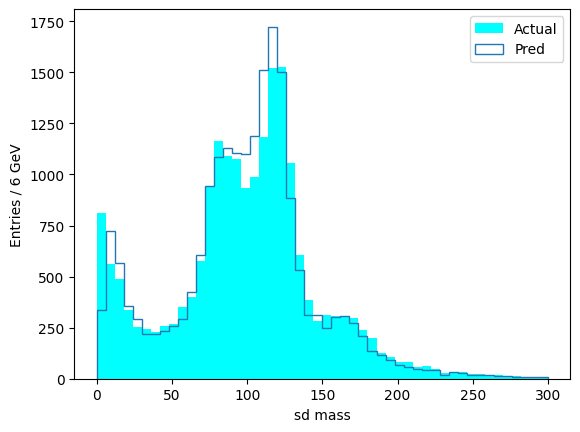

In [32]:
import matplotlib.pyplot as plt
plt.hist(sdm_act, bins=50, label="Actual", range=(0,300), histtype='stepfilled', color="cyan")
plt.hist(sdm_pred, bins=50, label="Pred", histtype='step', range=(0,300))
plt.legend()
plt.xlabel("sd mass")
plt.ylabel("Entries / 6 GeV")
plt.show()